# Mise en place du notebook

## Importation des modules

In [1]:
# Importation des modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd
from typing import Union
from sklearn.metrics import recall_score

# Ignorer les avertissements spécifiques de la bibliothèque XGBoost
import warnings
warnings.filterwarnings(action="ignore", module="xgboost")
import xgboost as xgb_

# Importation des éléments de "utilitaire.py"
from utilitaire import (
    SPECIES_AMPLICONS_FILE,
    RANDOMS_AMPLICONS_FILE,
    TEST_SET_FILE,
    VALIDATION_SET_FILE,
    RANDOM_STATE,
    encode_sp,
    plot_classReport,
    plot_data,
)

## Variables globales

In [2]:
###### Datasets ######

SPECIES_AMPLICONS: pd.DataFrame = pd.read_csv(filepath_or_buffer=SPECIES_AMPLICONS_FILE)
RANDOMS_AMPLICONS: pd.DataFrame = pd.read_csv(filepath_or_buffer=RANDOMS_AMPLICONS_FILE)
TEST_SET: pd.DataFrame = pd.read_csv(filepath_or_buffer=TEST_SET_FILE)
VALIDATION_SET: pd.DataFrame = pd.read_csv(filepath_or_buffer=VALIDATION_SET_FILE)

###### Datasets ######

###### Paramètres ######

N_ITER: int = 100
PARAMS: dict =  {"n_estimators": [100, 200, 400, 800],
                 "max_depth": [3, 5, 6, 10, 15, 20, None],
                 "learning_rate": [0.01, 0.1, 0.2, 0.3],
                 "subsample": np.arange(0.1, 1.01, 0.1),
                 "colsample_bytree": np.arange(0.1, 1.01, 0.1),
                 "colsample_bylevel": np.arange(0.1, 1.01, 0.1)}
RESULTS: list = [[0 for _ in range(0, len(PARAMS.keys()), 1)] for _ in range(0, N_ITER, 1)]

###### Paramètres ######

## Fonctions

In [3]:
def plot_learningCurve(classifier: object, sizes: Union[np.array, list] = np.arange(0.1, 1.01, 0.1), figsize: tuple = (14, 10), save: str = None) -> int:

    """ Plot la courbe d'apprentissage d'un modèle ."""

    # Initialiser les variables globales
    global x_train, x_test, y_train, y_test

    # Récupérer le nombre de séquences
    n_sample = len(y_train)
    
    # Initialiser les x
    x_ticks = [0]*len(sizes)

    # Initialiser les y
    scores = [0]*len(sizes)

    # Pour chaque faction
    for i, frac in enumerate(sizes):
        # Calculer le nombre d'échantillons équivalent à cette fraction
        n = round(n_sample*frac)
        
        # Ajouter le nombre à la liste des x
        x_ticks[i] = n
        
        # Ajouter le recall à la liste des y
        scores[i] = recall_score(y_true=y_test, y_pred=classifier.fit(x_train.iloc[:n], y_train.iloc[:n]).predict(x_test), average="micro")

    # Créer une figure
    plt.figure(figsize=figsize)

    # Plotter la courbe
    plt.plot(x_ticks, scores, color="#111111", label="Score")
    plt.scatter(x_ticks, scores, color="crimson")

    # Paramétrer la figure
    plt.grid()
    plt.xlabel("Train Size")
    plt.ylabel("Recall")
    plt.title("Learning Curve")
    plt.legend(loc="best")

    # Sauvegarder la figure
    if save != None:
        plt.savefig(save)

    # Afficher la figure
    plt.show()

    # Récupérer, et afficher, la meilleure taille d'échantillon
    best_size = sorted(zip(x_ticks, scores), key=lambda x: x[1], reverse=True)[0]
    print(f"Best_size: {best_size}")

    # Retourner la meilleure taille d'échantillon
    return best_size[0]

In [4]:
def search_params(size: int) -> list:

    """ Recherche les meilleurs paramètres pour le classifieur. """
    
    # Initialiser les variables globales
    global x_train, x_test, y_train, y_test

    # Pour le nombre d'itération passé
    for i in range(N_ITER):
        # Sélectionner aléatoirement des paramètres
        n_estimator = rd.choice(PARAMS["n_estimators"])
        max_depth = rd.choice(PARAMS["max_depth"])
        learning_rate = rd.choice(PARAMS["learning_rate"])
        subsample = rd.choice(PARAMS["subsample"])
        colsample_bytree = rd.choice(PARAMS["colsample_bytree"])
        colsample_bylevel = rd.choice(PARAMS["colsample_bylevel"])

        # Entrainer le modèle avec les paramètres
        xgb = xgb_.XGBClassifier(n_estimators=n_estimator,
                                 max_depth=max_depth, 
                                 learning_rate=learning_rate,
                                 subsample=subsample,
                                 colsample_bytree=colsample_bytree,
                                 colsample_bylevel=colsample_bylevel,
                                 random_state=RANDOM_STATE).fit(X=x_train.iloc[:size], y=y_train.iloc[:size])

        # Calculer le recall du modèle
        recall = recall_score(y_true=y_test, y_pred=xgb.predict(x_test), average="micro")
        
        # Afficher la progression
        print(f"[{i+1}/{N_ITER}] - Recall : {recall:.3f}", end='\r')

        # Ajouter le recall (et les paramètres) à la liste résultat
        RESULTS[i] = [n_estimator, max_depth, learning_rate, subsample, colsample_bytree, colsample_bylevel, recall]

    # Récupérer, et afficher, les meilleurs paramètres du modèle
    best_params = sorted(RESULTS, key=lambda x: x[6], reverse=True)[0]
    print(f"Best parameters: {best_params}")

    # Retourner les meilleurs paramètres du modèle
    return best_params

In [5]:
def plot_features_importances(classifier: object, figsize: tuple = (14, 10), save: str = None, color: str = "blue") -> None:
    
    """ Plotter l'importance de chaque features, sous forme d'un barplot. """

    # Créer la figure
    plt.figure(figsize=figsize)
    
    # Plotter la feature_importances, sous forme de barplot
    pd.Series(data=classifier.feature_importances_, index=[i for i in range(0, len(classifier.feature_importances_), 1)]).plot.bar(color=color)

    # Sauvegarder la figure
    if save != None:
        plt.savefig(save)

    # Afficher la figure
    plt.show()

# Recherche des meilleurs paramètres

## Splitting des données

In [6]:
# Créer le jeu d'entraînement, avec les séquences simulées
train = pd.concat(objs=[SPECIES_AMPLICONS, RANDOMS_AMPLICONS], axis=0).sample(frac=1.0, replace=False, random_state=RANDOM_STATE).reset_index(drop=True)

# Séparer les features et les labels du jeu d'entraînement
x_train, y_train = train.iloc[:,:-1], train.iloc[:, -1].apply(encode_sp)
display(x_train)

# Séparer les features et les labels du jeu de test
x_test, y_test = TEST_SET.iloc[:,:-1], TEST_SET.iloc[:, -1].apply(encode_sp)
display(x_test)

# Séparer les features et les labels du jeu de validation
x_val, y_val = VALIDATION_SET.iloc[:,:-1], VALIDATION_SET.iloc[:, -1].apply(encode_sp)
display(x_val)

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,4,3,4,4,2,1,1,2,2,3,...,4,3,1,3,1,3,4,0,0,0
1,4,3,4,4,2,1,1,2,2,3,...,4,3,4,3,1,3,1,3,4,0
2,4,3,4,4,2,1,1,2,2,3,...,3,1,3,1,3,4,0,0,0,0
3,4,3,4,4,2,1,1,2,2,3,...,1,3,1,3,4,0,0,0,0,0
4,4,3,4,4,2,1,1,2,2,3,...,4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,4,3,4,4,2,1,1,2,2,3,...,4,3,1,3,1,3,4,0,0,0
109996,4,3,4,4,2,1,1,2,2,3,...,3,4,0,0,0,0,0,0,0,0
109997,4,3,4,4,2,1,1,2,2,3,...,3,4,3,1,3,1,3,4,0,0
109998,4,3,4,4,2,1,1,2,2,3,...,1,3,4,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,4,3,4,4,2,1,1,2,2,3,...,1,4,2,4,0,0,0,0,0,0
1,4,3,4,4,2,1,1,2,2,3,...,4,0,0,0,0,0,0,0,0,0
2,4,3,4,4,2,1,1,2,2,3,...,1,4,2,4,0,0,0,0,0,0
3,4,3,4,4,2,1,1,2,2,3,...,4,2,4,0,0,0,0,0,0,0
4,4,3,4,4,2,1,1,2,2,3,...,4,2,4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15112,4,3,4,4,2,1,1,2,2,3,...,4,2,4,0,0,0,0,0,0,0
15113,4,3,4,4,2,1,1,2,2,3,...,4,2,4,0,0,0,0,0,0,0
15114,4,3,4,4,2,1,1,2,2,3,...,4,0,0,0,0,0,0,0,0,0
15115,4,3,4,4,2,1,1,2,2,3,...,4,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,4,3,4,4,2,1,1,2,2,3,...,4,1,4,2,4,0,0,0,0,0
1,4,3,4,4,2,1,1,2,2,3,...,4,0,0,0,0,0,0,0,0,0
2,4,3,4,4,2,1,1,2,2,3,...,4,1,4,2,4,0,0,0,0,0
3,4,3,4,4,2,1,1,2,2,3,...,4,2,4,0,0,0,0,0,0,0
4,4,3,4,4,2,1,1,2,2,3,...,4,1,4,2,4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33993,4,3,4,4,2,1,1,2,2,3,...,4,2,4,0,0,0,0,0,0,0
33994,4,3,4,4,2,1,1,2,2,3,...,4,0,0,0,0,0,0,0,0,0
33995,4,3,4,4,2,1,1,2,2,3,...,4,2,4,0,0,0,0,0,0,0
33996,4,3,4,4,2,1,1,2,2,3,...,1,4,2,4,0,0,0,0,0,0


## Plotting des données d'entraînement

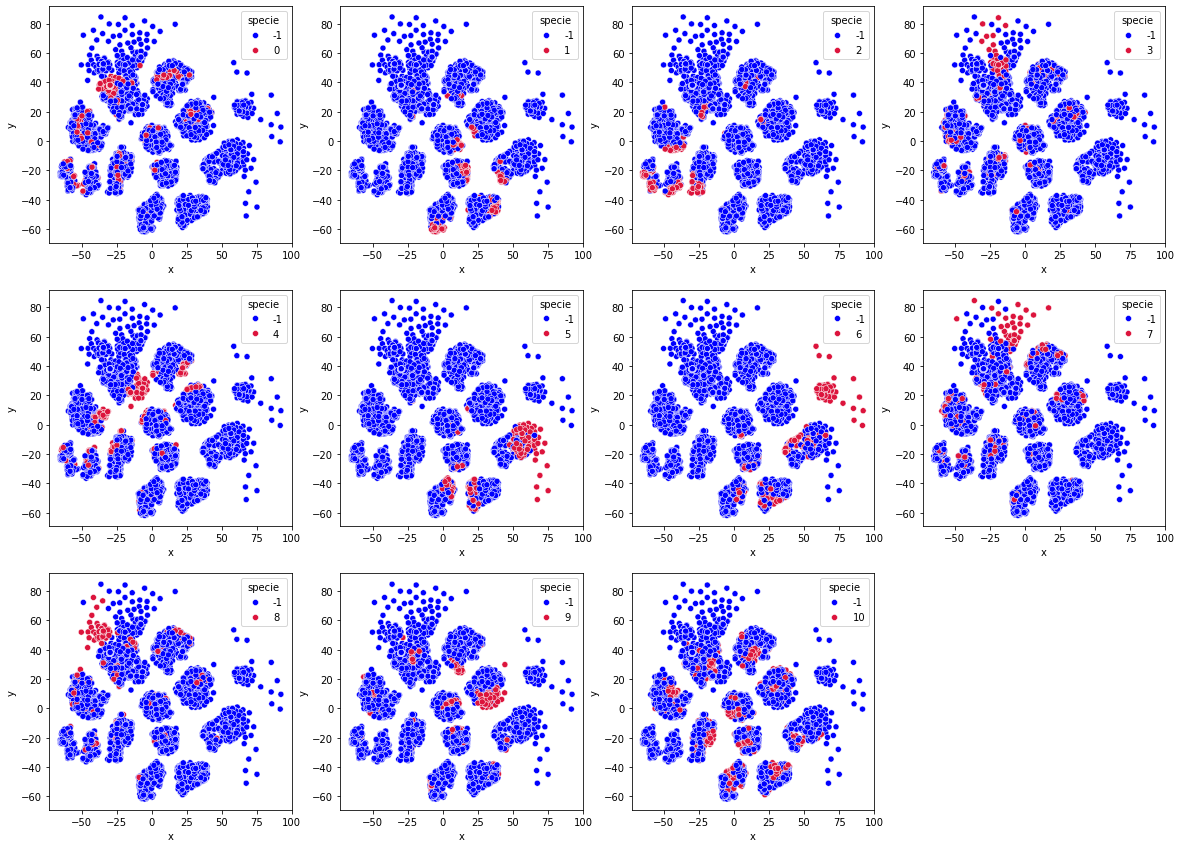

In [7]:
# Plotter le jeu d'entraînement
plot_data(X=x_train, y=y_train, palette=["blue", "crimson"])

## Entraînement du modèle de base 

In [8]:
# Faire un premier test de la performance du modèle, avec les paramètres de bases, et tout les données d'entraînement
xgb = xgb_.XGBClassifier(random_state=RANDOM_STATE).fit(X=x_train, y=y_train)

## Évaluation sur le train Set

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000
           2       1.00      1.00      1.00     10000
           3       1.00      1.00      1.00     10000
           4       1.00      1.00      1.00     10000
           5       0.96      0.99      0.97     10000
           6       0.99      0.96      0.97     10000
           7       1.00      1.00      1.00     10000
           8       1.00      1.00      1.00     10000
           9       1.00      1.00      1.00     10000
          10       1.00      1.00      1.00     10000

    accuracy                           0.99    110000
   macro avg       0.99      0.99      0.99    110000
weighted avg       0.99      0.99      0.99    110000



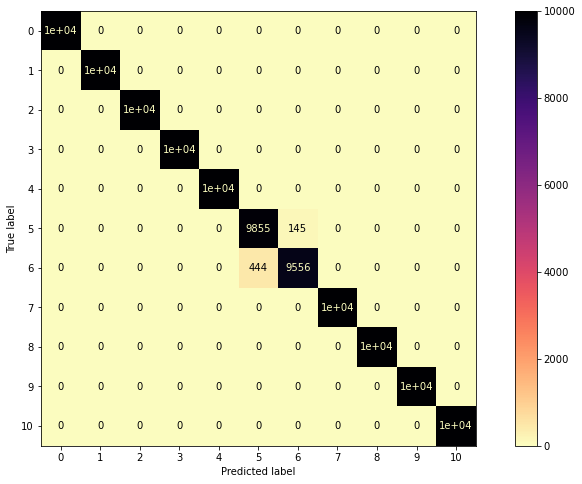

In [9]:
# Plotter les résultats d'entraînement
plot_classReport(classifier=xgb, X=x_train, y=y_train)

## Évaluation sur le test Set

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       1.00      1.00      1.00     15117
          10       0.00      0.00      0.00         0

    accuracy                           1.00     15117
   macro avg       0.11      0.11      0.11     15117
weighted avg       1.00      1.00      1.00     15117



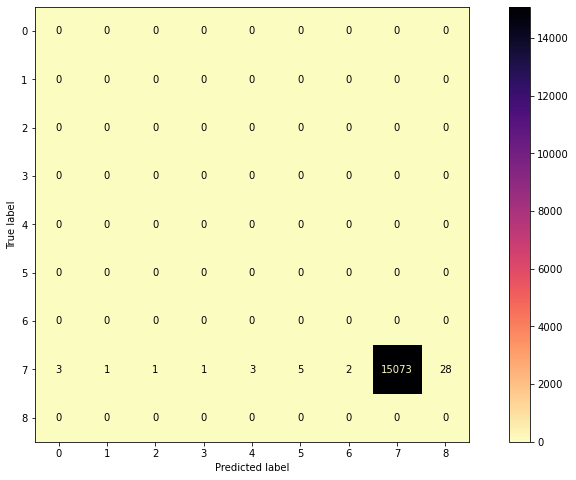

In [10]:
# Plotter les résultat de prédictions sur le test
plot_classReport(classifier=xgb, X=x_test, y=y_test)

## Recherche de la meilleure taille pour l'entraînement

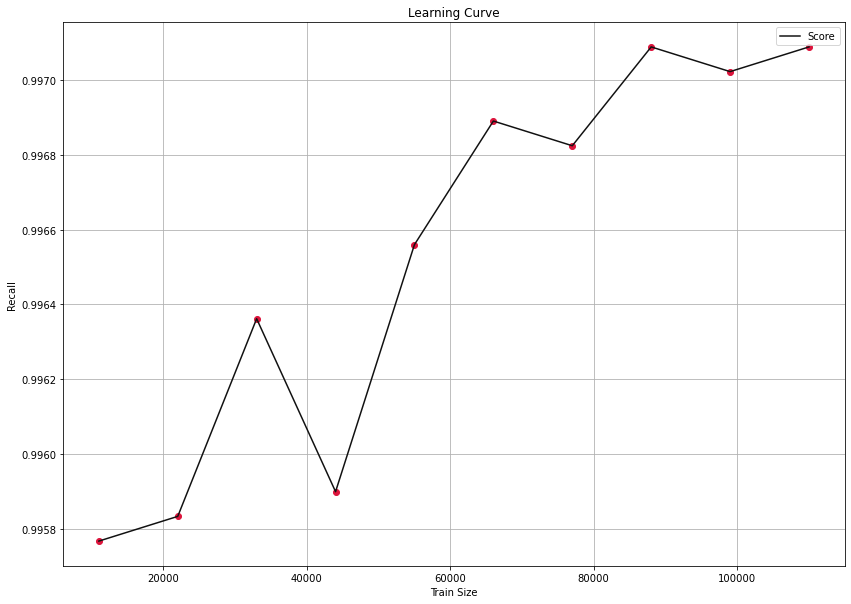

Best_size: (88000, 0.9970893695839121)


In [11]:
# Rechercher la taille optimale du jeu d'entraînement
best_size = plot_learningCurve(classifier=xgb_.XGBClassifier(random_state=RANDOM_STATE))

## Recherche des meilleures paramètres

In [12]:
# Rechercher les paramètres optimaux du modèle
best_params = search_params(size=best_size)

Best parameters: [800, 20, 0.3, 0.30000000000000004, 0.7000000000000001, 1.0, 0.9976185751141099]


## Entraînement du modèle optimisé

In [13]:
# Ré-entraîner le modèle avec les meilleurs paramètres
xgb = xgb_.XGBClassifier(
                n_estimators=best_params[0],
                max_depth=best_params[1],
                learning_rate=best_params[2],
                subsample=best_params[3],
                colsample_bytree=best_params[4],
                colsample_bylevel=best_params[5],
                random_state=RANDOM_STATE).fit(X=x_train.iloc[:best_size], y=y_train.iloc[:best_size])

## Évaluation sur le Validation Set

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           9       1.00      1.00      1.00     33998
          10       0.00      0.00      0.00         0

    accuracy                           1.00     33998
   macro avg       0.14      0.14      0.14     33998
weighted avg       1.00      1.00      1.00     33998



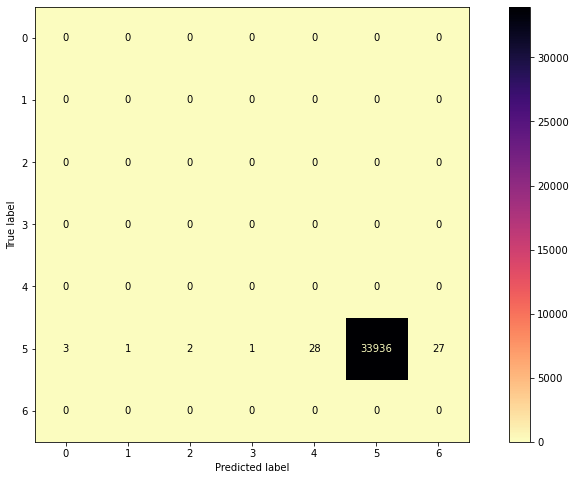

In [14]:
# Plotter les résultat de prédictions sur le validation
plot_classReport(classifier=xgb, X=x_val, y=y_val)

## Affichage des features importants

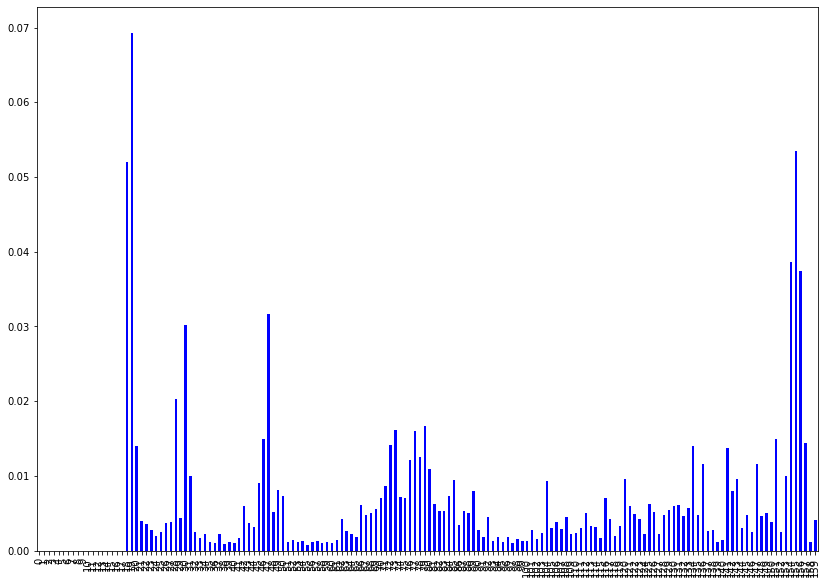

In [15]:
# Plotter l'importance que le modèle attribue à chaque feature
plot_features_importances(classifier=xgb)